In [1]:
from IPython.core.events import EventManager
from IPython import get_ipython
import time

global_start_time = None

def start_timer(event):
    global global_start_time
    global_start_time = time.time()

def stop_timer(event):
    global global_start_time
    if global_start_time:
        duration = time.time() - global_start_time
        print(f"Cell execution time: {duration:.3f} seconds")
        global_start_time = None

ip = get_ipython()
ip.events.register('pre_run_cell', start_timer)
ip.events.register('post_run_cell', stop_timer)

In [2]:
from skimage import io 
import pandas as pd 
import matplotlib.pyplot as plt
import gc
import numpy as np
from glob import glob 
import cv2
import matplotlib.colors as mcolors
from scipy.sparse import lil_matrix

Cell execution time: 1.217 seconds


In [4]:
red_denom = 2**16
blue_denom = 2**14
green_denom = 2**15
yellow_denom = 2**13

blue_adjust = 0.9    
yellow_adjust = 0.8  
red_adjust = 1.3 
green_adjust = 1.6

gamma = 1.1

Cell execution time: 0.000 seconds


In [5]:
imgR = io.imread("../channel/PTB22.2_Red.tiff")
rawR = np.clip(imgR /     red_denom,    0, 1)
imgR_norm = np.power(rawR, gamma) * red_adjust
del rawR
del imgR

gc.collect()

266

Cell execution time: 160.733 seconds


In [6]:
imgY = io.imread("../channel/PTB22.2_Yellow.tiff")
rawY = np.clip(imgY / yellow_denom,    0, 1)
imgY_norm = np.power(rawY, gamma) * yellow_adjust
del rawY
del imgY
gc.collect()

266

Cell execution time: 163.086 seconds


In [7]:
imgR_final = np.clip(imgR_norm + imgY_norm, 0, 1)
del imgR_norm
gc.collect()

0

Cell execution time: 129.377 seconds


In [8]:
imgG = io.imread("../channel/PTB22.2_Green.tiff")
rawG = np.clip(imgG /   green_denom,    0, 1)
imgG_norm = np.power(rawG, gamma) * green_adjust
del rawG
del imgG
gc.collect()

266

Cell execution time: 150.946 seconds


In [9]:
imgG_final = np.clip(imgG_norm + imgY_norm, 0, 1)
del imgY_norm
del imgG_norm
gc.collect()

0

Cell execution time: 141.084 seconds


In [10]:
imgB = io.imread("../channel/PTB22.2_Blue.tiff")
rawB = np.clip(imgB /    blue_denom,    0, 1)
imgB_norm = np.power(rawB, gamma) * blue_adjust
del rawB
del imgB

Cell execution time: 143.889 seconds


In [11]:
imgB_final = np.clip(imgB_norm, 0, 1)

Cell execution time: 13.452 seconds


In [12]:
del imgB_norm

Cell execution time: 1.720 seconds


In [13]:
# full composite scan, requires lot of memory 
img = np.stack((imgR_final,imgG_final, imgB_final), -1)

Cell execution time: 500.245 seconds


In [21]:
del imgR_final
del imgG_final
del imgB_final

Cell execution time: 0.000 seconds


In [22]:
gc.collect()

1801

Cell execution time: 0.049 seconds


In [23]:
df = pd.read_excel("../data/geomx_222.xlsx",sheet_name="SegmentProperties")
df = df.loc[df["SlideName"]=="PTB22.2"]
df = df[["ROILabel","ROICoordinateX","ROICoordinateY","AOISurfaceArea"]]

Cell execution time: 0.819 seconds


/Users/jperrie/miniconda3/envs/scvi/lib/python3.11/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [26]:
bb_fns = glob("../bb_mask/PTB222*")

Cell execution time: 0.001 seconds


In [76]:
img_path = "../bb_annot/PTB222_1.png"
tmp_img=plt.imread(img_path)
xw = np.floor(tmp_img.shape[1]/2).astype(int)

Cell execution time: 0.039 seconds


In [83]:
mask = lil_matrix(img.shape[:2], dtype=np.uint8)

Cell execution time: 0.202 seconds


In [84]:
# first estimate of text placement around bounding box 
font_dict = {i:(np.floor(xw/4).astype(int)-22,np.floor(xw/2).astype(int)) for i in df.ROILabel.values}

Cell execution time: 0.000 seconds


In [85]:
# second estimate of text placement 
for bbf in bb_fns:
    roi=bbf.split("_")[-1].split(".npy")[0]
    roi=int(roi)
    if roi not in df["ROILabel"].values:
        continue

    # bounding box 
    bb_mat = np.load(bbf)

    # resized bounding box used for estimates in text placement along y-axis 
    bbr_mat = cv2.resize(bb_mat.astype(float), (xw*2,xw*2), interpolation=cv2.INTER_LANCZOS4)

    font_dict[roi] = (font_dict[roi][0],np.where(bbr_mat.sum(1)>0)[0][0])
    if roi == 9:
        font_dict[roi] = (font_dict[roi][0],np.where(bbr_mat.sum(1)>0)[0][-1]+1100)
    if roi == 23:
        font_dict[roi] = (font_dict[roi][0],np.where(bbr_mat.sum(1)>0)[0][-1]+1100)
    if roi == 25:
        font_dict[roi] = (font_dict[roi][0]-300,np.where(bbr_mat.sum(1)>0)[0][0])
    if roi == 19:
        font_dict[roi] = (font_dict[roi][0]+200,np.where(bbr_mat.sum(1)>0)[0][0])

Cell execution time: 1.334 seconds


In [86]:
# iterate through each file, place the bounding box and text 
for bbf in bb_fns:
    # getting ROI and loading bounding box 
    roi=bbf.split("_")[-1].split(".npy")[0]
    roi=int(roi)
    if roi not in df["ROILabel"].values:
        continue

    bb_mat = np.load(bbf)

    ry,rx=df.loc[df["ROILabel"]==roi,["ROICoordinateX","ROICoordinateY"]].values[0]
    ry=np.int64(ry)
    rx=np.int64(rx)

    # bounding box has its middle filled in using contours 
    bbr_mat = cv2.resize(bb_mat.astype(float), (xw*2,xw*2), interpolation=cv2.INTER_LANCZOS4)

    bbr_bin = (bbr_mat > 0).astype(np.uint8)        
    contours, _ = cv2.findContours(
        bbr_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    fill_color = 2                                
    cv2.drawContours(bbr_mat, contours, -1, fill_color, thickness=-1)
    
    bbr_mat[bbr_mat>0.33] = roi

    region_mask = mask[(rx-xw):(rx+xw),(ry-xw):(ry+xw)].toarray()
    
    # we do not want to lose surrounding annotations from past spots 
    max_mat = np.maximum(region_mask, bbr_mat)

    # padded space placing text (at current font scale extends beyond xw) 
    pad = 800
    padded_mat = cv2.copyMakeBorder(
        max_mat.astype(np.uint8),
        pad, pad, pad, pad,
        borderType=cv2.BORDER_CONSTANT,
        value=0
    )

    text_mask = np.zeros_like(padded_mat)
    font = cv2.FONT_HERSHEY_COMPLEX
    font_scale = 24
    thickness = 48
    position = (xw-font_dict[roi][0]+400, font_dict[roi][1]+500)  
    white_color = (1)  
    cv2.putText(text_mask, str(roi).zfill(2), position, font, font_scale, white_color, thickness)

    
    padded_mat[text_mask > 0] = 100 + roi 

    r0 = rx - xw - pad
    r1 = rx + xw + pad
    c0 = ry - xw - pad
    c1 = ry + xw + pad

    sub_mask = mask[r0:r1, c0:c1].copy()
    sub_mask = sub_mask.toarray()

    # mask has encoding for each spot bounding box (roi int) and text (roi + 100 int) 
    mask[r0:r1, c0:c1] = np.maximum(sub_mask, padded_mat)

Cell execution time: 9.501 seconds


In [87]:
# simplify mask codes to just distinguish text and bounding boxes 
csr_mask = mask.tocsr()
d = csr_mask.data
d[(d > 1) & (d < 100)] = 1
d[d >= 100] = 2
mask = csr_mask.toarray()

Cell execution time: 0.184 seconds


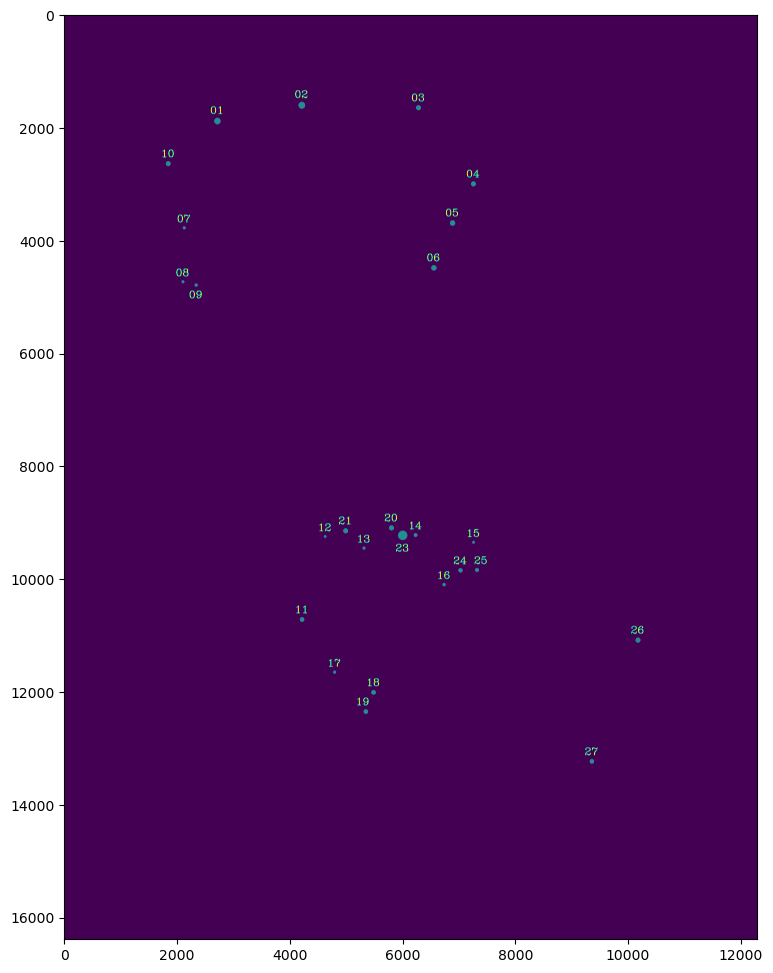

Cell execution time: 8.553 seconds


In [88]:
# downsize mask and plot to see if placement is adequate 
mask_small = cv2.resize(mask, (mask.shape[1]//4, mask.shape[0]//4),
                         interpolation=cv2.INTER_NEAREST)
fig,ax=plt.subplots(figsize=(12,12))
plt.imshow(mask_small)

In [89]:
# downsize image 
img_small  = cv2.resize(img,   (img.shape[1]//4, img.shape[0]//4),
                         interpolation=cv2.INTER_AREA)
img_small = cv2.cvtColor((img_small * 255).clip(0, 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

Cell execution time: 64.350 seconds


In [90]:
# save image using mask overlay 
mask_small = (mask_small > 0).astype(np.uint8)


overlay = np.zeros_like(img_small, dtype=np.uint8)
overlay[mask_small == 1] = (255, 255, 255)  

alpha = 0.5                                 
blended = cv2.addWeighted(img_small, 1.0,
                          overlay,   alpha, 0)

cv2.imwrite("../plots/ptb222_label.png", blended)

True

Cell execution time: 4.800 seconds
